In [99]:
import torch # torch has to go first because of some odd TLS bug

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print("CUDA available: %s" % torch.cuda.is_available())


from math import *
from functools import partial
import operator
import itertools

import qutip as qt
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

CUDA available: False


## Consistency of Matrix Operations

To simplify ptrace operations, we need to ensure to have the environment at the front in channel+environment constructions.

### Reshape

In [2]:
np.reshape(np.array([[2, 3], [15, 228]]), [-1, 1])

array([[  2],
       [  3],
       [ 15],
       [228]])

In [3]:
torch.FloatTensor([[2, 3], [15, 228]]).view(-1, 1)#.view(-1, 2)

tensor([[  2.],
        [  3.],
        [ 15.],
        [228.]])

In [4]:
# this would require a transpose! but as long as our qobject is symmetric it's not a problem;
# transposes can break memory alignment and cache coherence so they're better avoided
qt.operator_to_vector(qt.Qobj([[2, 3], [15, 228]]))

Quantum object: dims = [[[2], [2]], [1]], shape = (4, 1), type = operator-ket
Qobj data =
[[  2.]
 [ 15.]
 [  3.]
 [228.]]

### Partial Trace

In [5]:
# partial trace
foo = qt.Qobj(np.random.rand(4,4), dims=[[2, 2], [2, 2]])
print(foo)
foo.ptrace((1))

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0.70098567 0.13364949 0.18836781 0.76311209]
 [0.86544295 0.73142367 0.44030512 0.72340197]
 [0.19831715 0.74382779 0.6979501  0.19016715]
 [0.41413078 0.12707559 0.57248314 0.30710427]]


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[1.39893577 0.32381664]
 [1.43792609 1.03852795]]

In [6]:
foonp = foo.full().real
sum([ foonp[2*i:2*i+2,2*i:2*i+2] for i in range(2) ])

array([[1.39893577, 0.32381664],
       [1.43792609, 1.03852795]])

## Depolarizing Channel

In [7]:
# defined such that p=.25 is the threshold for zero coherent information
# expects one or more arguments
def qubit_depolarizing_channel(*p):
    def _qubit_depolarizing_channel(pp):
        i = qt.identity(2)
        [x, y, z] = [qt.sigmax(), qt.sigmay(), qt.sigmaz()]
        return (1-pp*3/4) * qt.to_super(i) + pp*3/4/3 * (qt.to_super(x) + qt.to_super(y) + qt.to_super(z))
    
    return qt.super_tensor(*[ _qubit_depolarizing_channel(pp) for pp in p ])

qubit_depolarizing_channel(.2)

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True
Qobj data =
[[0.9 0.  0.  0.1]
 [0.  0.8 0.  0. ]
 [0.  0.  0.8 0. ]
 [0.1 0.  0.  0.9]]

## CI

### Qutip

In [8]:
# random real state
def random_re(dims):
    return qt.Qobj(np.random.rand(np.prod(dims))-.5, dims=[dims,[1]*len(dims)]).unit()
random_re([2,2])

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.42313432]
 [-0.77549502]
 [-0.15954251]
 [-0.44058031]]

In [9]:
def get_channel_and_environment(channel, purification_dim):
    environment = qt.to_super(qt.identity(list(purification_dim)))
    return qt.super_tensor(environment, channel) # channel to the back for easier ptrace implementations

def coherent_information(
    channel,
    psi,
    verbose=False
):
    # first few dimensions _not_ present in channel
    purification_dim = psi.dims[0][:-len(channel.dims[0][0])]
    
    verbose and print("environment dims: %s ..." % purification_dim)
    
    channel_and_environment = get_channel_and_environment(channel, tuple(purification_dim))
    channel_and_environment_dims = channel_and_environment.dims[0][0]
    channel_indices = list(range(
        len(purification_dim),
        len(channel_and_environment_dims)
    )) # channel is rightmost indices

    verbose and print("full dim: %s, channel indices: %s" % (channel_and_environment_dims, channel_indices))
    
    return -qt.entropy_conditional(
        qt.vector_to_operator(channel_and_environment * qt.operator_to_vector(qt.ket2dm(psi))),
        channel_indices,
        base=2
    )

[
    print(p/100, np.mean([
        coherent_information( qubit_depolarizing_channel(p/100), random_re([2, 2]) )
        for _ in range(10)
    ]))
    for p in range(21, 30, 1)
];

0.21 0.02772716246374194
0.22 0.03241502580649865
0.23 0.010833797002301148
0.24 -0.008784341618684022
0.25 -0.014309550754382182
0.26 -0.02600097347240089
0.27 -0.041053836055613746
0.28 -0.056861058378585384
0.29 -0.05220420342425458


### Torch

In [93]:
# this is slow
def apply(f, M, dim):
    return torch.stack(
        [ f(m) for m in torch.unbind(M, dim=dim) ],
        dim=dim
    )

In [10]:
def SetSysEnv(sys, env, dim_qudit=2):
    assert(dim_qudit>=2 and sys>=1 and env>=1)
    assert(env <= sys)
    
    global DIM_QUDIT, SYS, ENV, BOTH, DIM_SYS, DIM_ENV, DIM_BOTH, DIM_RHO
    DIM_QUDIT = dim_qudit
    SYS = sys
    ENV = env
    BOTH = sys + env

    # calculate dimensions
    DIM_SYS = DIM_QUDIT ** SYS
    DIM_ENV = DIM_QUDIT ** ENV
    DIM_BOTH = DIM_SYS * DIM_ENV
    DIM_RHO = DIM_BOTH ** 2
    
SetSysEnv(2, 1)

In [198]:
torch.ones(10).size(0)

10

In [206]:
def TorchChannelFactory(*p):    
    # build channel N and id . N for environment
    channel = qubit_depolarizing_channel(*p)
    channel_and_environment = qt.super_tensor(qt.to_super(qt.identity(DIM_ENV)), channel)
    assert(channel_and_environment.shape == (DIM_RHO, DIM_RHO))

    # convert to constant variables for use in torch
    indices = torch.from_numpy(np.array(qubit_depolarizing_channel(.1).data.nonzero()).astype('long'))
    values = torch.from_numpy(np.real(qubit_depolarizing_channel(.1).data.data).astype('float32'))
    size = torch.Size(channel_and_environment.shape)
    channel_and_environment_var = Variable(torch.sparse.FloatTensor(indices, values, size), requires_grad=False)
    
    return channel_and_environment_var

SetSysEnv(1, 0)
TorchChannelFactory(.4).to_dense()

AssertionError: 

In [200]:
def torchCI(channel, psi):
    assert(1 <= len(psi.size()) <= 2)
    batched = len(psi.size()) == 2
    
    def _torchCI(channel, psi):
        d = psi.size(0)
        assert(len(channel.size()) == 2 and channel.size(0) == channel.size(1))
        assert(channel.size(0) == d*d)

        # to density matrix
        rho = psi.ger(psi)

        # apply channel
        rhoSE = channel.mm(rho.view(-1, 1)).view(-1, d)

        # partial trace; crucial that environment is up front
        def ptrace(m):
            return sum([
                m.narrow(0, i*DIM_SYS, DIM_SYS).narrow(1, i*DIM_SYS, DIM_SYS)
                for i in range(DIM_ENV)
            ])

        rhoS = ptrace(rhoSE)

        # vn entropy
        def vn_entropy(m):
            evals = torch.svd(m)[1] # use symeig once torch supports gradients on it
            nonzeros = torch.where(evals != 0, evals, torch.ones(evals.size(0)))
            return sum(nonzeros * torch.log2(nonzeros))

        return -(vn_entropy(rhoS) - vn_entropy(rhoSE))
    
    if not batched:
        return _torchCI(channel, psi)
    
    return sum(apply(partial(_torchCI, channel), psi, dim=0))

# test that we get a differentiable CI
def test_torchCI():
    SetSysEnv(2, 1)
    psi=Variable(torch.randn(3, 8), requires_grad=True)
    #print(psi.ger(psi))
    print(torchCI(TorchChannelFactory(.1, .1), psi))
test_torchCI()

tensor(0., grad_fn=<ThAddBackward>)


### Comparison

In [201]:
SetSysEnv(3, 1)
psi = random_re([2, 2, 2, 2])
psi

Quantum object: dims = [[2, 2, 2, 2], [1, 1, 1, 1]], shape = (16, 1), type = ket
Qobj data =
[[ 0.19492779]
 [-0.12202581]
 [-0.37468232]
 [-0.47097769]
 [ 0.22469755]
 [-0.3965801 ]
 [ 0.14977493]
 [-0.09792609]
 [ 0.00975497]
 [ 0.04966089]
 [-0.3116993 ]
 [-0.04897414]
 [ 0.04828797]
 [-0.13048227]
 [-0.38737491]
 [ 0.27126788]]

In [202]:
coherent_information(qubit_depolarizing_channel(.14, .14, .14), psi, verbose=True)

environment dims: [2] ...
full dim: [2, 2, 2, 2], channel indices: [1, 2, 3]


0.3274569919978294

In [203]:
psiT = Variable(torch.from_numpy(psi.dag().full().real.astype('float32')).squeeze(), requires_grad=False)
psiT

tensor([ 0.1949, -0.1220, -0.3747, -0.4710,  0.2247, -0.3966,  0.1498, -0.0979,
         0.0098,  0.0497, -0.3117, -0.0490,  0.0483, -0.1305, -0.3874,  0.2713])

In [204]:
SetSysEnv(3, 1)
torchCI(TorchChannelFactory(.14, .14, .14), psiT)

tensor(-0.)

## Autoencoder

In [89]:
# quantum normalization layer
class QuantumNormalize(nn.Module):
    def __init__(self):
        super(QuantumNormalize, self).__init__()

    def forward(self, input):
        assert(1<= len(input.size()) <= 2) # expecting vector or minibatch
        batched = len(input.size()) == 2
        norm = input.norm(p=2, dim=1 if batched else 0, keepdim=True)
        return input.div(norm.expand_as(input))

    def extra_repr(self):
        return 'quantum state normalization such that squared elements add up to 1'


In [150]:
# the NN
class AutoencoderNet(nn.Module):
    def __init__(self, input_nodes=30):
        super(AutoencoderNet, self).__init__()
        
        self.input_nodes = input_nodes
        self.output_nodes = DIM_BOTH
                
        # network architecture
        [dim1, dim2, dim3, dim4] = [ int(d) for d in np.linspace(self.input_nodes, self.output_nodes, 4) ]
        
        self.model = nn.Sequential(
            nn.Linear(self.input_nodes, dim1),
            nn.ELU(),
            nn.Linear(dim1, dim2),
            nn.ELU(), # ELUs, yo!
            nn.BatchNorm1d(dim2),
            
            nn.Linear(dim2, dim3),
            nn.ELU(),
            nn.Linear(dim3, dim4),
            QuantumNormalize()
        )
                
    def initialize(self):
        for p in self.parameters():
            nn.init.uniform_(p)
        return self
                
    def forward(self, x):
        return self.model(x)   
    
    def noise(self, batch_size):
        return Variable(torch.rand(batch_size, self.input_nodes), requires_grad=False)
    
    def instance(self, batch_size=2):
        return self(self.noise(batch_size))
    
    # nondeterministic!
    def instance_Qobj(self, batch_size=2):
        return qt.Qobj(self.instance(batch_size).detach().numpy()[0], dims=[[DIM_QUDIT]*BOTH, [1]*BOTH])
    

net = AutoencoderNet().initialize()
print(net)
    
print(net.instance_Qobj(2))

AutoencoderNet(
  (model): Sequential(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=30, out_features=25, bias=True)
    (3): ELU(alpha=1.0)
    (4): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=25, out_features=20, bias=True)
    (6): ELU(alpha=1.0)
    (7): Linear(in_features=20, out_features=16, bias=True)
    (8): QuantumNormalize(quantum state normalization such that squared elements add up to 1)
  )
)
Quantum object: dims = [[2, 2, 2, 2], [1, 1, 1, 1]], shape = (16, 1), type = ket
Qobj data =
[[0.26912236]
 [0.20553903]
 [0.24429616]
 [0.22448236]
 [0.28772604]
 [0.2828702 ]
 [0.22586383]
 [0.21114421]
 [0.25071317]
 [0.22086182]
 [0.30420268]
 [0.25175789]
 [0.19182917]
 [0.25277847]
 [0.30563292]
 [0.23492658]]


In [151]:
SetSysEnv(3, 1)
net = AutoencoderNet().initialize()
print(net)

channel = TorchChannelFactory(.25, .25, .25)

def criterion(state):
    return -torchCI(channel, state)
    
# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=.0002)

# scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=99, factor=1/2, min_lr=.000001, verbose=True)

# few rounds of optimization
running = 1.
outputs = []
for epoch in range(20000):
    # train
    optimizer.zero_grad()
    loss = criterion(net.instance(10)) # 40 batches simultaneously
    loss.backward()
    optimizer.step()
    
    # adjust learning rate
    scheduler.step(loss)

    # print some updates
    current = loss.item()
    running = .99*running + .01*current
    if epoch % 100 == 0:
        print("[%04d] CI=%+8.2g CI_avg=%+8.2g" % (epoch//100, -current, -running))
        outputs.append(net.instance_Qobj())

AutoencoderNet(
  (model): Sequential(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=30, out_features=25, bias=True)
    (3): ELU(alpha=1.0)
    (4): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=25, out_features=20, bias=True)
    (6): ELU(alpha=1.0)
    (7): Linear(in_features=20, out_features=16, bias=True)
    (8): QuantumNormalize(quantum state normalization such that squared elements add up to 1)
  )
)
[0000] CI=  -0.095 CI_avg=   -0.99
[0001] CI=  -0.041 CI_avg=    -0.4
[0002] CI=  -0.018 CI_avg=   -0.16
[0003] CI= -0.0024 CI_avg=  -0.063
[0004] CI= -0.0022 CI_avg=  -0.025
[0005] CI= -0.0012 CI_avg=  -0.011
Epoch   564: reducing learning rate of group 0 to 1.0000e-04.
[0006] CI= -0.0081 CI_avg= -0.0055
Epoch   664: reducing learning rate of group 0 to 5.0000e-05.
[0007] CI=  -0.016 CI_avg= -0.0037
Epoch   764: reducing learning rate of group 0 to 2.5000

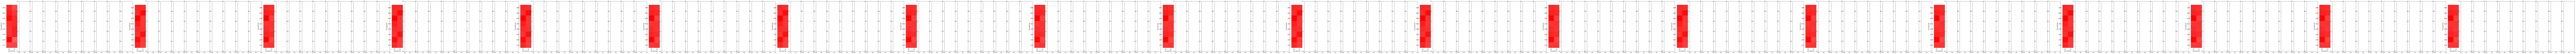

In [152]:
def visualize_training():
    n = len(outputs)
    fig, _ = plt.subplots(1, n, figsize=(2*n, DIM_SYS))
    for i, q in enumerate(outputs):
        if i % 10:
            continue
        ax = plt.subplot(1, n, i+1)
        qt.plot_schmidt(q, SYS, labels_iteration=(SYS, ENV), fig=fig, ax=ax);
    
visualize_training()

## Standard FF-Quantum State Net

In [56]:
class Sin(nn.Module):
    def forward(self, x):
        return x.sin()

In [109]:
# the NN
class StateNet(nn.Module):
    def __init__(self):
        super(StateNet, self).__init__()
        
        self.input_nodes = BOTH
        self.output_nodes = 1
        
        # basis states for purified state
        self.basis_states = [
            Variable(torch.FloatTensor(i), requires_grad=False) # constants
            for i in itertools.product(*[list(range(2))] * BOTH)
        ]
        assert(len(self.basis_states) == DIM_BOTH)
        
        # network architecture
        [dim1, dim2, dim3, dim4] = [ int(d) for d in np.linspace(self.input_nodes, self.output_nodes, 4) ]
        
        self.model = nn.Sequential(
            nn.Linear(self.input_nodes, dim1),
            Sin(),
            nn.Linear(dim1, dim2),
            nn.LeakyReLU(),
            nn.Linear(dim2, dim3),
            nn.LeakyReLU(),
            nn.Linear(dim3, dim4)
        )
        
        self.normalize = QuantumNormalize()
        
    def initialize(self):
        for p in self.parameters():
            nn.init.uniform_(p)
        return self
                
    def forward(self, x):
        return self.model(x)   
    
    def to_state(self):
        return self.normalize(
            torch.stack([
                self(w) for w in self.basis_states # get output of NN for each basis input
            ]).squeeze()
        )
    
    def to_Qobj(self):
        data = self.to_state().detach().numpy()
        return qt.Qobj(data, dims=[[DIM_QUDIT] * BOTH, [1] * BOTH]).unit()
    

net = StateNet().initialize()
print(net)
    
print(net.to_state())

StateNet(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): Sin()
    (2): Linear(in_features=4, out_features=3, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=3, out_features=2, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=2, out_features=1, bias=True)
  )
  (normalize): QuantumNormalize(quantum state normalization such that squared elements add up to 1)
)
tensor([0.2020, 0.2104, 0.2491, 0.2555, 0.2550, 0.2510, 0.2692, 0.2629, 0.2518,
        0.2537, 0.2686, 0.2679, 0.2635, 0.2537, 0.2430, 0.2310],
       grad_fn=<DivBackward1>)


### Train State Net

In [110]:
SetSysEnv(3, 1)
net = StateNet().initialize()
print(net)

channel = TorchChannelFactory(.2, .2, .2)

def criterion(state):
    return -torchCI(channel, state)
    
# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=.001)

# scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=1/2, min_lr=.00001, verbose=True)

# few rounds of optimization
running = 1.
plots=[]
for epoch in range(2000):
    # train
    optimizer.zero_grad()
    loss = criterion(net.to_state())
    loss.backward()
    optimizer.step()
    
    # adjust learning rate
    scheduler.step(loss)

    # print some updates
    current = loss.item()
    running = .99*running + .01*current
    if epoch % 100 == 0:
        print("[%04d] CI=%+8.2g CI_avg=%+8.2g" % (epoch//100, -current, -running))
        plots += [net.to_Qobj()];

StateNet(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): Sin()
    (2): Linear(in_features=4, out_features=3, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=3, out_features=2, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=2, out_features=1, bias=True)
  )
  (normalize): QuantumNormalize(quantum state normalization such that squared elements add up to 1)
)
[0000] CI= -0.0017 CI_avg=   -0.99
[0001] CI=-0.00056 CI_avg=   -0.36
[0002] CI=-0.00015 CI_avg=   -0.13
[0003] CI=-3.6e-05 CI_avg=  -0.049
[0004] CI=-1.2e-05 CI_avg=  -0.018
[0005] CI=-4.6e-06 CI_avg= -0.0065
[0006] CI=-1.9e-06 CI_avg= -0.0024
[0007] CI=-1.3e-06 CI_avg=-0.00088
[0008] CI=-1.9e-06 CI_avg=-0.00032
Epoch   878: reducing learning rate of group 0 to 5.0000e-04.
[0009] CI=-1.8e-06 CI_avg=-0.00012
Epoch   979: reducing learning rate of group 0 to 2.5000e-04.
[0010] CI=-1.3e-06 CI_avg=-4.5e-05
Epoch  1080: reducing lea

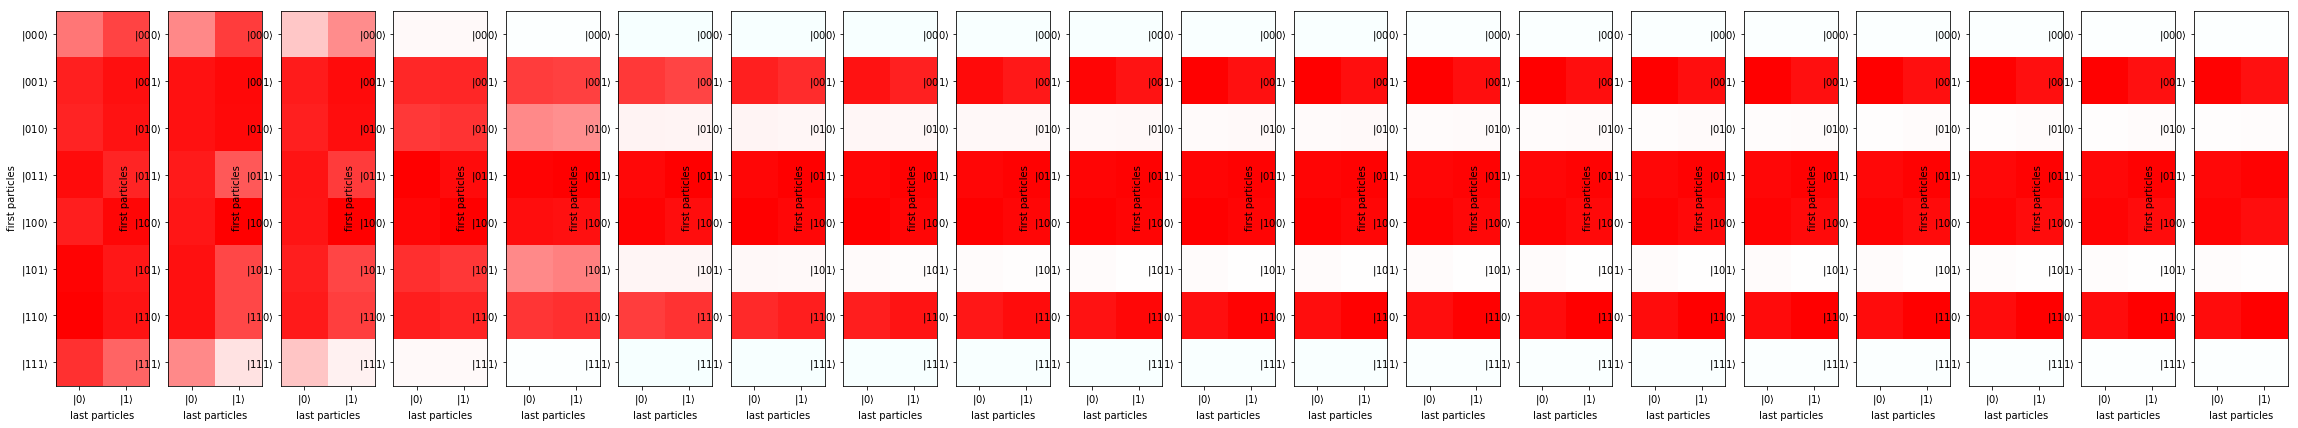

In [64]:
def visualize_training():
    n = len(plots)
    fig, _ = plt.subplots(1, n, figsize=(2*n, DIM_SYS))
    for i, q in enumerate(plots):
        ax = plt.subplot(1, n, i+1)
        qt.plot_schmidt(q, SYS, labels_iteration=(SYS, ENV), fig=fig, ax=ax);
    
visualize_training()